In [1]:
import os
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tt
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
import torchvision.models as models
%matplotlib inline
from copy import copy

In [2]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:31<00:00, 37.1MB/s]
100% 1.03G/1.03G [00:31<00:00, 34.9MB/s]


In [4]:
! unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
%cd /content

os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [8]:
ls

asl_alphabet_test/   asl-alphabet.zip  sample_data/
asl_alphabet_train/  kaggle.json


In [9]:
classes = os.listdir("./asl_alphabet_train/asl_alphabet_train")
num_classes = len(classes)

In [10]:

# Data transforms (data augmentation)
# stats = ((0.5190, 0.4992, 0.5140),(0.2038, 0.2283, 0.2356))
train_tfms = tt.Compose([tt.RandomCrop(200, padding=25, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(10),
                         tt.RandomPerspective(distortion_scale=0.2),
                         tt.ToTensor()
                        ])
test_tfms = tt.Compose([tt.ToTensor()])

dataset = ImageFolder('./asl_alphabet_train/asl_alphabet_train')

In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [12]:
val_size = int(0.15 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

train_ds.dataset = copy(dataset)
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = test_tfms

In [13]:
batch_size = 50
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 200, 200])
Label: C


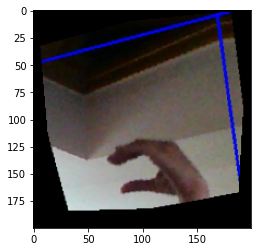

In [17]:
img, label = train_ds[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


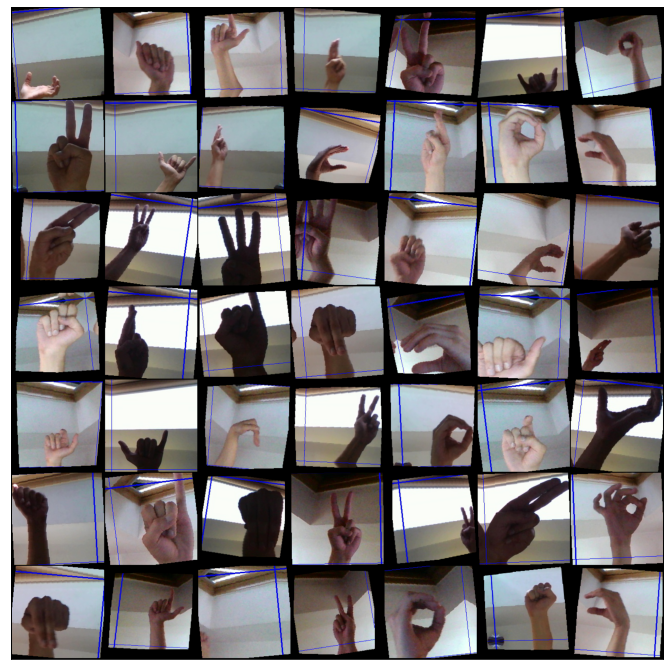

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:49], nrow=7).permute(1, 2, 0))
        break

show_batch(train_dl)

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [23]:
num_classes

29

In [24]:
class ASLResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [25]:
model = to_device(ASLResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ASLResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.028473282232880592, 'val_loss': 3.5470306873321533}]

In [38]:
model.freeze()

In [39]:
epochs = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0028, val_acc: 0.9993
Epoch [1], val_loss: 0.0022, val_acc: 0.9993
Epoch [2], val_loss: 0.0061, val_acc: 0.9979
Epoch [3], val_loss: 0.0024, val_acc: 0.9995
Epoch [4], val_loss: 0.0081, val_acc: 0.9974
Epoch [5], val_loss: 0.0029, val_acc: 0.9989
Epoch [6], val_loss: 0.0016, val_acc: 0.9998
Epoch [7], val_loss: 0.0004, val_acc: 0.9999
Epoch [8], val_loss: 0.0001, val_acc: 1.0000
Epoch [9], val_loss: 0.0001, val_acc: 1.0000
CPU times: user 37min 35s, sys: 27min 3s, total: 1h 4min 38s
Wall time: 1h 6min 41s


In [41]:
model.unfreeze()

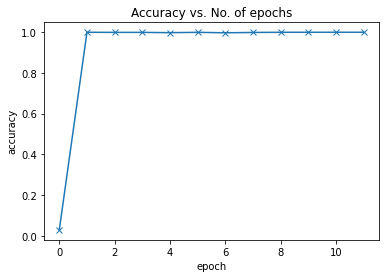

In [42]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [1]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

NameError: ignored

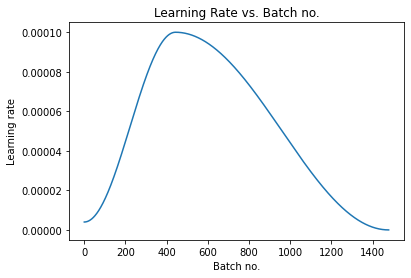

In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

Predicted: E


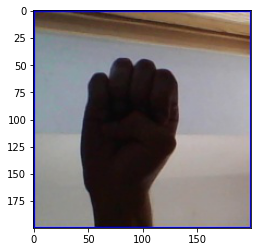

In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

test_dataset = ImageFolder('./asl_alphabet_test')

test_ds, _ = random_split(test_dataset, [28, 0])

test_ds.dataset.transform = tt.Compose([tt.ToTensor()])

img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))